In [1]:
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
tc.cuda.is_available()

True

In [6]:
from torchvision.datasets import MNIST

train = MNIST("", download=True, train=True)
test = MNIST("", download=True, train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 899871.70it/s] 


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133616.84it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 245879.84it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9515748.64it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [7]:
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

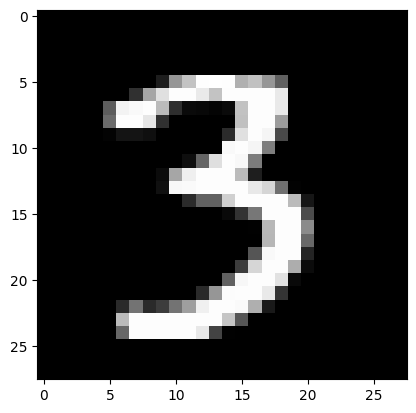

The number in the image is 3


In [8]:
image = X_train[10000]
label = y_train[10000]

plt.imshow(image, cmap="gray")
plt.show()
print("The number in the image is", label.numpy())

In [9]:
y = tc.cat((y_train, y_test)).numpy()

In [10]:
pd.Series(y).value_counts().sort_index()

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64

In [11]:
pd.Series(y).value_counts().sort_values()

5    6313
4    6824
8    6825
6    6876
0    6903
9    6958
2    6990
3    7141
7    7293
1    7877
Name: count, dtype: int64

In [12]:
print("Size of X_train is", X_train.numpy().shape)
print("Size of y_train is", y_train.numpy().shape)
print("Size of X_test is", X_test.numpy().shape)
print("Size of y_test is", y_test.numpy().shape)

Size of X_train is (60000, 28, 28)
Size of y_train is (60000,)
Size of X_test is (10000, 28, 28)
Size of y_test is (10000,)


In [13]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [14]:
print("Size of X_train is", X_train.numpy().shape)
print("Size of X_test is", X_test.numpy().shape)

Size of X_train is (60000, 1, 28, 28)
Size of X_test is (10000, 1, 28, 28)


In [15]:
X_train = X_train.cuda()
y_train = y_train.cuda()
X_test = X_test.cuda()
y_test = y_test.cuda()

In [16]:
X_train = X_train.float() / 255
X_test = X_test.float() / 255

In [17]:
mean = tc.mean(X_train, dim=(0, 2, 3))
std = tc.std(X_train, dim=(0, 2, 3))

In [18]:
print("Mean of X_train is", np.squeeze(mean.cpu().numpy()))
print("Standard deviation of X_train is", np.squeeze(std.cpu().numpy()))

Mean of X_train is 0.13066047
Standard deviation of X_train is 0.30810782


In [19]:
X_train = (X_train - mean[None, :, None, None]) / std[None, :, None, None]
X_test = (X_test - mean[None, :, None, None]) / std[None, :, None, None]

In [20]:
import torch.nn as nn
import torch.nn.init as init


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        init.xavier_normal_(self.conv1.weight)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        init.xavier_normal_(self.conv2.weight)

        self.fc3 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc3_dropout = nn.Dropout(0.2)
        init.xavier_normal_(self.fc3.weight)

        self.fc4 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc4_dropout = nn.Dropout(0.1)
        init.xavier_normal_(self.fc4.weight)

        self.fc5 = nn.Linear(84, 10)
        init.xavier_normal_(self.fc5.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = tc.tanh(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tc.tanh(x)
        x = self.pool2(x)

        x = tc.flatten(x, 1)

        x = self.fc3(x)
        x = self.bn3(x)
        x = tc.tanh(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = tc.tanh(x)
        x = self.fc4_dropout(x)

        x = self.fc5(x)

        return x

In [21]:
import torch.optim as optim

model = LeNet5()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=9e-3, weight_decay=3e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [22]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 5
losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_val_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)

    model.eval()

    with tc.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            epoch_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    model.train()

    print(
        f"Epoch: {epoch + 1}/{epochs}, Training Loss: {losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}"
    )

Epoch: 1/5, Training Loss: 0.1461, Validation Loss: 0.0829
Epoch: 2/5, Training Loss: 0.0607, Validation Loss: 0.0367
Epoch: 3/5, Training Loss: 0.0411, Validation Loss: 0.0294
Epoch: 4/5, Training Loss: 0.0316, Validation Loss: 0.0222
Epoch: 5/5, Training Loss: 0.0271, Validation Loss: 0.0193


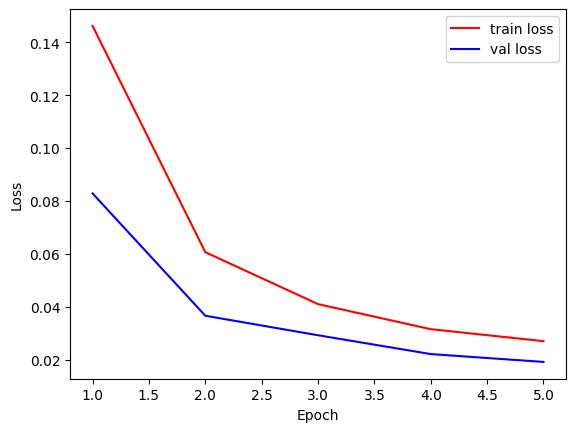

In [23]:
plt.plot(range(1, epochs + 1), losses, color="red", label="train loss")
plt.plot(range(1, epochs + 1), val_losses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
model.eval()

with tc.no_grad():
    train_pred = tc.argmax(model(X_train), dim=1)
    test_pred = tc.argmax(model(X_test), dim=1)

In [25]:
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()
train_pred = train_pred.cpu().numpy()
test_pred = test_pred.cpu().numpy()

In [26]:
from sklearn.metrics import accuracy_score

print(f"Training accuracy is {100 * accuracy_score(y_train, train_pred):.2f}%")
print(f"Testing accuracy is {100 * accuracy_score(y_test, test_pred):.2f}%")

Training accuracy is 99.61%
Testing accuracy is 99.27%


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Precision score is {100 * precision_score(y_test, test_pred, average='weighted'):.2f}%")
print(f"Recall score is {100 * recall_score(y_test, test_pred, average='weighted'):.2f}%")
print(f"F1 score is {100 * f1_score(y_test, test_pred, average='weighted'):.2f}%")

Precision score is 99.27%
Recall score is 99.27%
F1 score is 99.27%


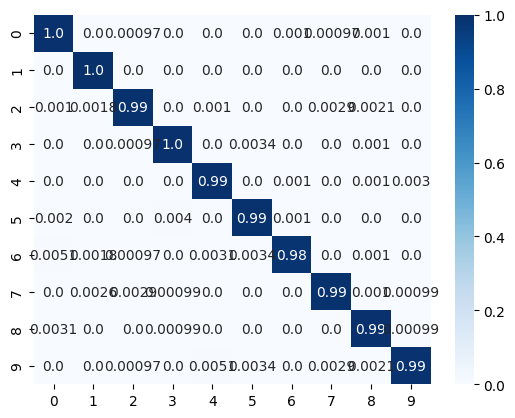

In [28]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, test_pred)

sb.heatmap(cfm / np.sum(cfm, axis=1), annot=True, fmt=".2", cmap="Blues")
plt.show()

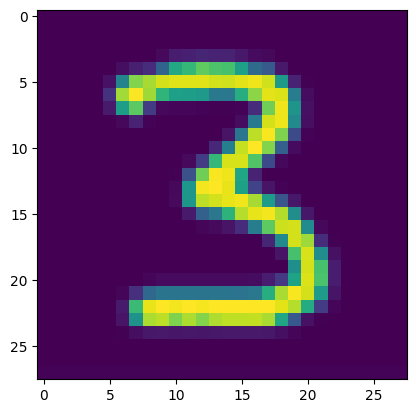

In [29]:
from PIL import Image

image = np.array(Image.open("/content/drive/My Drive/Google Colab/number.png").resize((28, 28)).convert("L"))

plt.imshow(image)
plt.show()

In [30]:
image = tc.from_numpy(image).float()
image = image.unsqueeze(0).unsqueeze(0)
image = image.cuda()

In [31]:
print("Size of image is", image.cpu().numpy().shape)

Size of image is (1, 1, 28, 28)


In [32]:
image = image / 255
image = (image - mean[None, :, None, None]) / std[None, :, None, None]

In [33]:
model.eval()

with tc.no_grad():
    prediction = tc.argmax(model(image), dim=1)

print("The model predicts the number", np.squeeze(prediction.cpu().numpy()), "in the image")

The model predicts the number 3 in the image


In [34]:
tc.save(model, "model.pth")

In [35]:
from google.colab import files

files.download("model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>